## Conclusion from SQL and panda pre analysis
### Observation
* The code of a control area is unique. A control area will only have one unit and multiple SCPs but units may be duplicate among stations. Linename is messy. => Just use Control Area
* Time is not consistent too. => Use morning/afternoon/night...
* Get needed columns to save almost 100 mb
* Can keep desc-recovered but will need to clean duplicate data with both regular and recovered
* SQL query may be faster

### Completed
* Query data from database
* Clean duplicate data with both regular and recovered
* Create datetime frame
* Substract entries and exits to get the numbers
* Clean data
* Substract entries and exits by time

### To do
* Data analysis
* Time analysis

In [1]:
#*****need to run*****
from sqlalchemy import create_engine
#from sqlalchemy import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
#*****need to run*****
engine = create_engine("sqlite:///mta.db")

In [3]:
#*****need to run*****
#df = pd.read_sql('SELECT ca, scp, station, date, time, desc, entries, exits FROM mta_data;', engine)
df = pd.read_sql('''SELECT ca, scp, station, date, time, desc, entries, exits FROM mta_data
                    WHERE date NOT IN ("02/27/2021", "02/28/2021", "06/01/2021", 
                                       "06/02/2021", "06/03/2021", "06/04/2021")
                    ORDER BY ca, date, time, scp, desc;''', engine)

In [4]:
#*****need to run*****
df["o_index"] = df.index
df["o_index"]
#drop duplicate data with wrong recover audit first
mask_dup = df[(df["o_index"] == 300706) |
          (df["o_index"] == 1089956) |
          (df["o_index"] == 1382146) |
          (df["o_index"] == 1382154) |
          ((df["CA"] == "N100") &
           (df["SCP"] == "00-00-00") &
           (df["ENTRIES"] == 818272) &
           (df["o_index"] != 842617))].index
df.drop(mask_dup, inplace= True)
#then, drop duplicate data with wrong regular data
df.drop_duplicates(subset=["CA", "SCP", "STATION", "DATE", "TIME"], keep= 'last', inplace=True)
df.drop(['o_index'], axis = 1, inplace = True)
df.reset_index(drop = True, inplace = True)
#datatime series
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")
df["DAY"] = df["DATE_TIME"].dt.weekday
#period calculation
df.sort_values(["CA", "SCP","DATE_TIME"], inplace=True)
df["PRE_ENTRIES"] = df.ENTRIES.shift(1)
df["PRE_EXITS"] = df.EXITS.shift(1)
df["PRE_TIME"] = df.DATE_TIME.shift(1)
df["PERIOD_ENTRIES"] = df.ENTRIES.diff(1)
df["PERIOD_EXITS"] = df.EXITS.diff(1)
#clean data
df.dropna(inplace=True)
df.drop(df[(df["PERIOD_ENTRIES"] < 0) | (df["PERIOD_EXITS"] < 0)].index, inplace=True)
df.drop(df[(df["DATE_TIME"] < df["PRE_TIME"])].index, inplace=True)
df.drop(df[((df["CA"] == "PTH03") & (df["SCP"] == "00-01-08") & (df["PRE_EXITS"] == 0.0))].index, inplace=True)
df.drop(df[(df["DATE_TIME"] - df["PRE_TIME"] > timedelta(days = 1))].index, inplace=True)
df.drop(df[(df["PERIOD_ENTRIES"] > 10000) | (df["PERIOD_EXITS"] > 10000)].index, inplace=True)
df["PERIOD_VISITS"] = df["PERIOD_ENTRIES"] + df["PERIOD_EXITS"]
df.reset_index(drop = True, inplace = True)

In [5]:
df.describe()

,ENTRIES,EXITS,DAY,PRE_ENTRIES,PRE_EXITS,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS
count,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06,2.712197e+06
mean,2.916385e+07,2.167306e+07,2.967840e+00,2.916380e+07,2.167300e+07,5.244576e+01,5.704746e+01,1.094932e+02
std,1.688733e+08,1.421759e+08,2.009990e+00,1.688733e+08,1.421759e+08,7.756442e+01,9.111144e+01,1.413103e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.132380e+05,8.959400e+04,1.000000e+00,2.132050e+05,8.955100e+04,2.000000e+00,4.000000e+00,1.000000e+01
50%,1.405713e+06,8.381460e+05,3.000000e+00,1.405659e+06,8.380980e+05,2.100000e+01,2.300000e+01,5.800000e+01
75%,5.852690e+06,3.821718e+06,5.000000e+00,5.852616e+06,3.821683e+06,7.100000e+01,7.200000e+01,1.570000e+02
max,2.147419e+09,2.049250e+09,6.000000e+00,2.147419e+09,2.049250e+09,1.510000e+03,3.416000e+03,4.926000e+03


In [6]:
df.sample(3)

,CA,SCP,STATION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,DAY,PRE_ENTRIES,PRE_EXITS,PRE_TIME,PERIOD_ENTRIES,PERIOD_EXITS,PERIOD_VISITS
2048993,R227A,01-06-00,23 ST,04/27/2021,05:00:00,REGULAR,3092772,3405952,2021-04-27 05:00:00,1,3092772.0,3405952.0,2021-04-27 01:00:00,0.0,0.0,0.0
2454543,R519,00-00-00,46 ST BLISS ST,03/22/2021,20:00:00,REGULAR,1845556,2805061,2021-03-22 20:00:00,0,1845468.0,2805010.0,2021-03-22 16:00:00,88.0,51.0,139.0
1003157,N218,01-05-01,FORDHAM RD,04/20/2021,16:00:00,REGULAR,327680,65593,2021-04-20 16:00:00,1,327680.0,65593.0,2021-04-20 12:00:00,0.0,0.0,0.0


In [7]:
dup = (df
       .groupby(["CA", "SCP", "STATION", "DATE", "TIME"])
       .ENTRIES.count()
       .reset_index()
       .sort_values("ENTRIES"))
dup[dup.ENTRIES > 1].shape

(0, 6)

In [8]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712197 entries, 0 to 2712196
Data columns (total 16 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   CA              2712197 non-null  object        
 1   SCP             2712197 non-null  object        
 2   STATION         2712197 non-null  object        
 3   DATE            2712197 non-null  object        
 4   TIME            2712197 non-null  object        
 5   DESC            2712197 non-null  object        
 6   ENTRIES         2712197 non-null  int64         
 7   EXITS           2712197 non-null  int64         
 8   DATE_TIME       2712197 non-null  datetime64[ns]
 9   DAY             2712197 non-null  int64         
 10  PRE_ENTRIES     2712197 non-null  float64       
 11  PRE_EXITS       2712197 non-null  float64       
 12  PRE_TIME        2712197 non-null  datetime64[ns]
 13  PERIOD_ENTRIES  2712197 non-null  float64       
 14  PERIOD_EXITS    27

In [9]:
for col in df:
    print(col, df[col].nunique())

CA 750
SCP 222
STATION 379
DATE 92
TIME 56712
DESC 2
ENTRIES 1775443
EXITS 1686012
DATE_TIME 173829
DAY 7
PRE_ENTRIES 1774964
PRE_EXITS 1685812
PRE_TIME 173826
PERIOD_ENTRIES 927
PERIOD_EXITS 1404
PERIOD_VISITS 1593


In [10]:
for col in df:
    print(df[col].value_counts())

PTH22    23484
R610     13771
PTH03    13475
PTH02    12143
PTH16    12030
         ...  
H037      1102
J022      1102
N215      1099
A085       551
OB01       307
Name: CA, Length: 750, dtype: int64
00-00-01    249238
00-00-00    247705
00-00-02    222957
00-00-03    113157
00-03-00     98253
             ...  
03-01-08       521
01-00-0A       521
00-04-09       520
02-02-04       518
03-01-07       506
Name: SCP, Length: 222, dtype: int64
34 ST-PENN STA     55662
FULTON ST          52896
GRD CNTRL-42 ST    47955
23 ST              39672
86 ST              35394
                   ...  
225 ST              1104
CLEVELAND ST        1102
SUTTER AV           1102
182-183 STS         1099
ORCHARD BEACH        307
Name: STATION, Length: 379, dtype: int64
04/12/2021    30004
03/19/2021    29839
03/16/2021    29812
04/07/2021    29763
04/05/2021    29724
              ...  
05/05/2021    29467
04/20/2021    29467
05/14/2021    29423
03/14/2021    26871
03/01/2021    24597
Name: DATE, Lengt

In [11]:
#*********must run*********
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.last())
#(df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.max())
daily_max = (df
             .groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
             .agg({"ENTRIES":"max", "EXITS":"max"})
             .rename(columns={"ENTRIES": "ENTRIES_MAX", "EXITS": "EXITS_MAX"}))
daily_max

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX
0,A002,02-00-00,59 ST,03/01/2021,7538400,2570968
1,A002,02-00-00,59 ST,03/02/2021,7538926,2571211
2,A002,02-00-00,59 ST,03/03/2021,7539503,2571472
3,A002,02-00-00,59 ST,03/04/2021,7540040,2571750
4,A002,02-00-00,59 ST,03/05/2021,7540626,2572022
...,...,...,...,...,...,...
454991,TRAM2,00-05-01,RIT-ROOSEVELT,05/27/2021,5554,577
454992,TRAM2,00-05-01,RIT-ROOSEVELT,05/28/2021,5554,577
454993,TRAM2,00-05-01,RIT-ROOSEVELT,05/29/2021,5554,577
454994,TRAM2,00-05-01,RIT-ROOSEVELT,05/30/2021,5554,577


In [12]:
#*********must run*********
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.first())
#turnstiles_daily = (df.groupby(["CA", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.min())
daily_min = (df
             .groupby(["CA", "SCP", "STATION", "DATE"], as_index=False)
             .agg({"ENTRIES":"min", "EXITS":"min"})
             .rename(columns={"ENTRIES": "ENTRIES_MIN", "EXITS": "EXITS_MIN"}))
daily_min

,CA,SCP,STATION,DATE,ENTRIES_MIN,EXITS_MIN
0,A002,02-00-00,59 ST,03/01/2021,7537862,2570742
1,A002,02-00-00,59 ST,03/02/2021,7538409,2570969
2,A002,02-00-00,59 ST,03/03/2021,7538938,2571214
3,A002,02-00-00,59 ST,03/04/2021,7539514,2571474
4,A002,02-00-00,59 ST,03/05/2021,7540050,2571750
...,...,...,...,...,...,...
454991,TRAM2,00-05-01,RIT-ROOSEVELT,05/27/2021,5554,577
454992,TRAM2,00-05-01,RIT-ROOSEVELT,05/28/2021,5554,577
454993,TRAM2,00-05-01,RIT-ROOSEVELT,05/29/2021,5554,577
454994,TRAM2,00-05-01,RIT-ROOSEVELT,05/30/2021,5554,577


In [13]:
#*********must run*********
#SCP daily level
daily = pd.merge(daily_max, daily_min, on = ["CA", "SCP", "STATION", "DATE"])
daily["ENTRIES_DAILY"] = daily["ENTRIES_MAX"] - daily["ENTRIES_MIN"]
daily["EXITS_DAILY"] = daily["EXITS_MAX"] - daily["EXITS_MIN"]
daily["SUM_DAILY"] = daily["ENTRIES_DAILY"] + daily["EXITS_DAILY"]
daily["DATE"] = pd.to_datetime(daily.DATE, format="%m/%d/%Y")
daily["DAY"] = daily["DATE"].dt.weekday
daily

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX,ENTRIES_MIN,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY
0,A002,02-00-00,59 ST,2021-03-01,7538400,2570968,7537862,2570742,538,226,764,0
1,A002,02-00-00,59 ST,2021-03-02,7538926,2571211,7538409,2570969,517,242,759,1
2,A002,02-00-00,59 ST,2021-03-03,7539503,2571472,7538938,2571214,565,258,823,2
3,A002,02-00-00,59 ST,2021-03-04,7540040,2571750,7539514,2571474,526,276,802,3
4,A002,02-00-00,59 ST,2021-03-05,7540626,2572022,7540050,2571750,576,272,848,4
...,...,...,...,...,...,...,...,...,...,...,...,...
454991,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-27,5554,577,5554,577,0,0,0,3
454992,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-28,5554,577,5554,577,0,0,0,4
454993,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-29,5554,577,5554,577,0,0,0,5
454994,TRAM2,00-05-01,RIT-ROOSEVELT,2021-05-30,5554,577,5554,577,0,0,0,6


In [14]:
daily[daily["ENTRIES_DAILY"] < 0]

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX,ENTRIES_MIN,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY


In [15]:
daily[daily["EXITS_DAILY"] < 0]

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX,ENTRIES_MIN,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY


In [16]:
#*********must run*********
mask_outlier = daily[(daily["ENTRIES_DAILY"] < 0) |
                     (daily["EXITS_DAILY"] < 0) |
                     (daily["ENTRIES_DAILY"] > 30000) |
                     (daily["EXITS_DAILY"] > 30000)].index
daily.drop(mask_outlier, inplace= True)
daily.sort_values("SUM_DAILY", ascending=False)

,CA,SCP,STATION,DATE,ENTRIES_MAX,EXITS_MAX,ENTRIES_MIN,EXITS_MIN,ENTRIES_DAILY,EXITS_DAILY,SUM_DAILY,DAY
280325,PTH22,00-01-04,PATH NEW WTC,2021-03-05,26234,24186,204,302,26030,23884,49914,4
312659,R160,02-03-00,66 ST-LINCOLN,2021-04-25,28817,15367,75,30,28742,15337,44079,6
279666,PTH22,00-00-04,PATH NEW WTC,2021-05-05,22986,18622,272,451,22714,18171,40885,2
278930,PTH21,01-00-01,PATH WTC 2,2021-05-05,18868,17581,62,130,18806,17451,36257,2
279784,PTH22,00-00-05,PATH NEW WTC,2021-05-31,20339,14353,170,53,20169,14300,34469,0
...,...,...,...,...,...,...,...,...,...,...,...,...
342721,R226,02-06-01,23 ST,2021-05-09,1,602,1,602,0,0,0,6
422421,R532H,02-03-03,METS-WILLETS PT,2021-03-12,415782,621039,415782,621039,0,0,0,4
342718,R226,02-06-01,23 ST,2021-05-06,1,599,1,599,0,0,0,3
342717,R226,02-06-01,23 ST,2021-05-05,1,599,1,599,0,0,0,2


In [17]:
#*********must run*********
#CA daily level
ca_daily = (daily.groupby(["CA", "STATION", "DATE", "DAY"], as_index=False)
                 .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
ca_daily

,CA,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,A002,59 ST,2021-03-01,0,7052,4046,3006
1,A002,59 ST,2021-03-02,1,7845,4336,3509
2,A002,59 ST,2021-03-03,2,8219,4447,3772
3,A002,59 ST,2021-03-04,3,7982,4376,3606
4,A002,59 ST,2021-03-05,4,8045,4436,3609
...,...,...,...,...,...,...,...
68911,TRAM2,RIT-ROOSEVELT,2021-05-27,3,1975,1940,35
68912,TRAM2,RIT-ROOSEVELT,2021-05-28,4,1638,1608,30
68913,TRAM2,RIT-ROOSEVELT,2021-05-29,5,1347,1311,36
68914,TRAM2,RIT-ROOSEVELT,2021-05-30,6,1068,1029,39


In [18]:
#*********must run*********
#station daily level
station_daily = (daily.groupby(["STATION", "DATE", "DAY"], as_index=False)
                      .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
station_daily

,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,1 AV,2021-03-01,0,14173,5775,8398
1,1 AV,2021-03-02,1,15688,6085,9603
2,1 AV,2021-03-03,2,16251,6365,9886
3,1 AV,2021-03-04,3,16202,6290,9912
4,1 AV,2021-03-05,4,17031,6377,10654
...,...,...,...,...,...,...
34779,ZEREGA AV,2021-05-27,3,2347,1130,1217
34780,ZEREGA AV,2021-05-28,4,2218,1056,1162
34781,ZEREGA AV,2021-05-29,5,1138,531,607
34782,ZEREGA AV,2021-05-30,6,875,400,475


In [19]:
#station 3_month level
station_3_month = (daily.groupby(["STATION"], as_index=False)
                        .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
station_3_month.sort_values("SUM_DAILY", ascending=False)

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
61,34 ST-PENN STA,6414929,2728496,3686433
59,34 ST-HERALD SQ,5015308,2111267,2904041
110,86 ST,4904169,2150541,2753628
233,GRD CNTRL-42 ST,4546456,1889633,2656823
14,14 ST-UNION SQ,4518167,1856719,2661448
...,...,...,...,...
148,BEACH 98 ST,24131,10161,13970
354,TOMPKINSVILLE,22474,22474,0
141,BEACH 105 ST,13882,5046,8836
162,BROAD CHANNEL,12265,8383,3882


In [20]:
top_10_station = station_3_month.sort_values("SUM_DAILY", ascending=False).head(10)
top_10_station

,STATION,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
61,34 ST-PENN STA,6414929,2728496,3686433
59,34 ST-HERALD SQ,5015308,2111267,2904041
110,86 ST,4904169,2150541,2753628
233,GRD CNTRL-42 ST,4546456,1889633,2656823
14,14 ST-UNION SQ,4518167,1856719,2661448
9,125 ST,4493839,2017090,2476749
46,23 ST,4030295,1853129,2177166
68,42 ST-PORT AUTH,3836121,1686167,2149954
226,FULTON ST,3513523,1534834,1978689
217,FLUSHING-MAIN,3473994,1703372,1770622


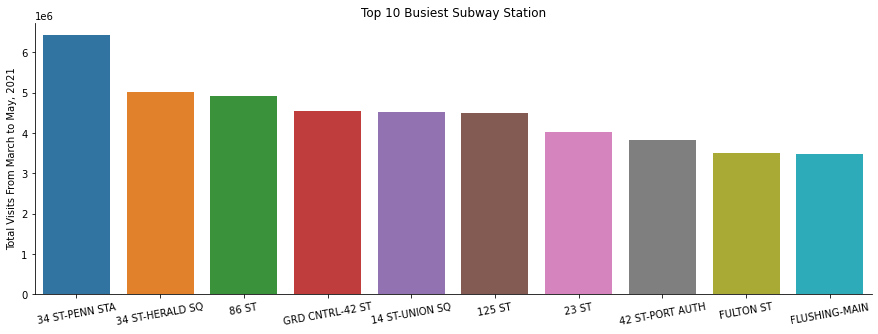

In [21]:
plt.figure(figsize=(15,5))
sns.barplot(x='STATION', y='SUM_DAILY', data=top_10_station)
plt.title("Top 10 Busiest Subway Station")
plt.xticks(fontsize = '10', rotation = 10)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("Total Visits From March to May, 2021", fontsize = '10')
sns.despine()
plt.savefig("top10_sum_daily_visit_staition.png", dpi = 200);

In [22]:
#Station avg
station_daily_avg = (station_daily.groupby(["STATION"], as_index=False)
                                  .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"mean", "EXITS_DAILY":"mean"})
                                  .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
top10_avg_staition = station_daily_avg.sort_values("AVG_DAILY", ascending=False).head(10)
top10_avg_staition

,STATION,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
61,34 ST-PENN STA,69727.489130,29657.565217,40069.923913
59,34 ST-HERALD SQ,54514.217391,22948.554348,31565.663043
110,86 ST,53306.184783,23375.445652,29930.739130
233,GRD CNTRL-42 ST,49418.000000,20539.489130,28878.510870
14,14 ST-UNION SQ,49110.510870,20181.728261,28928.782609
9,125 ST,48846.076087,21924.891304,26921.184783
46,23 ST,43807.554348,20142.706522,23664.847826
68,42 ST-PORT AUTH,41696.967391,18327.902174,23369.065217
226,FULTON ST,38190.467391,16682.978261,21507.489130
217,FLUSHING-MAIN,37760.804348,18514.913043,19245.891304


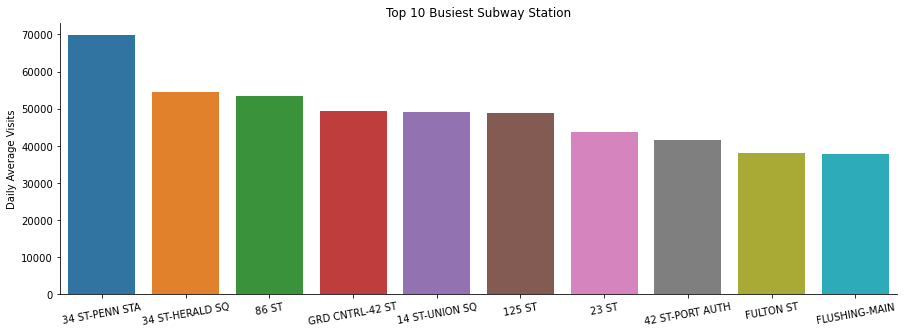

In [23]:
plt.figure(figsize=(15,5))
sns.barplot(x='STATION', y='AVG_DAILY', data=top10_avg_staition)
plt.title("Top 10 Busiest Subway Station")
plt.xticks(fontsize = '10', rotation = 10)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("Daily Average Visits", fontsize = '10')
sns.despine()
plt.savefig("top10_avg_daily_visit_staition.png", dpi = 200);

In [24]:
#weekday daily level
day_daily_sum = (daily.groupby(["DAY"], as_index=False)
                  .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
day_daily_sum

,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,0,43380826,21284345,22096481
1,1,43642200,21461126,22181074
2,2,43996700,21618621,22378079
3,3,43876746,21527535,22349211
4,4,44328977,21622311,22706666
5,5,29481694,13716089,15765605
6,6,21738153,9978823,11759330


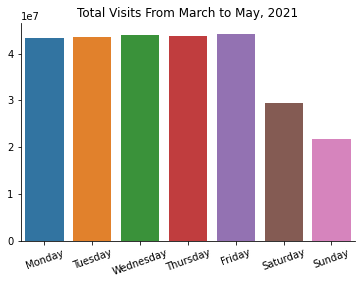

In [25]:
sns.barplot(x='DAY', y='SUM_DAILY', data=day_daily_sum)
plt.title("Total Visits From March to May, 2021")
plt.xticks(range(7), 
           ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 
           fontsize = '10', rotation = 20)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("")
sns.despine()
plt.savefig("total_visit_day.png", dpi = 200);

In [26]:
#sum_by_date level
sum_by_date = (daily.groupby(["DATE", "DAY"], as_index=False)
                        .agg({"SUM_DAILY":"sum", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"}))
sum_by_date

,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,2021-03-01,0,2837508,1393506,1444002
1,2021-03-02,1,3092470,1531328,1561142
2,2021-03-03,2,3244876,1605534,1639342
3,2021-03-04,3,3193006,1571550,1621456
4,2021-03-05,4,3221050,1581561,1639489
...,...,...,...,...,...
87,2021-05-27,3,3820790,1856052,1964738
88,2021-05-28,4,3664554,1769557,1894997
89,2021-05-29,5,2175792,1004847,1170945
90,2021-05-30,6,1686167,763204,922963


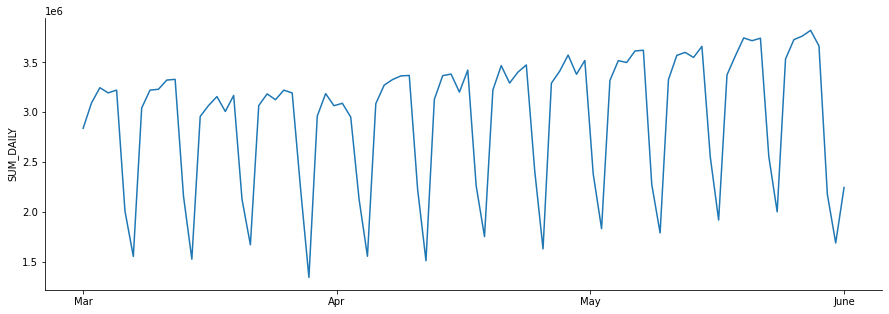

In [27]:
plt.figure(figsize=(15,5))
sns.lineplot(data=sum_by_date, x=sum_by_date.index, y="SUM_DAILY") 
#sns.regplot(data=sum_by_date, x=sum_by_date.index, y="SUM_DAILY")
plt.xticks(np.linspace(0,91,4), ['Mar', 'Apr', 'May', 'June'], fontsize = '10')
sns.despine()
plt.savefig("total_visit_by_date.png", dpi = 200);


In [28]:
#avg day visits
day_avg = (sum_by_date.groupby(["DAY"], as_index=False)
                      .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"mean", "EXITS_DAILY":"mean"})
                      .round()
                      .astype(int)
                      .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
day_avg

,DAY,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,0,3098630,1520310,1578320
1,1,3357092,1650856,1706236
2,2,3384362,1662971,1721391
3,3,3375134,1655964,1719170
4,4,3409921,1663255,1746667
5,5,2267823,1055084,1212739
6,6,1672166,767602,904564


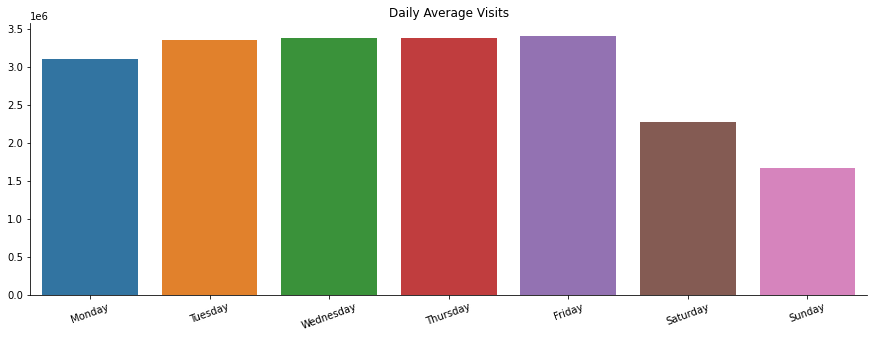

In [29]:
plt.figure(figsize=(15,5))
#sns.lineplot(x='DAY', y='AVG_DAILY', data=day_avg)
sns.barplot(x='DAY', y='AVG_DAILY', data=day_avg)
plt.title("Daily Average Visits")
plt.xticks(range(7), 
           ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 
           fontsize = '10', rotation = 20)
plt.yticks(fontsize = '10')
plt.xlabel("")
plt.ylabel("", fontsize = '10')
sns.despine()
plt.savefig("avg_daily_visit_day.png", dpi = 200);

In [30]:
ca_daily

,CA,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
0,A002,59 ST,2021-03-01,0,7052,4046,3006
1,A002,59 ST,2021-03-02,1,7845,4336,3509
2,A002,59 ST,2021-03-03,2,8219,4447,3772
3,A002,59 ST,2021-03-04,3,7982,4376,3606
4,A002,59 ST,2021-03-05,4,8045,4436,3609
...,...,...,...,...,...,...,...
68911,TRAM2,RIT-ROOSEVELT,2021-05-27,3,1975,1940,35
68912,TRAM2,RIT-ROOSEVELT,2021-05-28,4,1638,1608,30
68913,TRAM2,RIT-ROOSEVELT,2021-05-29,5,1347,1311,36
68914,TRAM2,RIT-ROOSEVELT,2021-05-30,6,1068,1029,39


In [31]:
ca_daily.sort_values("SUM_DAILY", ascending=False).head(5)

,CA,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
42240,PTH22,PATH NEW WTC,2021-03-05,4,73179,37662,35517
42301,PTH22,PATH NEW WTC,2021-05-05,2,59442,32118,27324
42327,PTH22,PATH NEW WTC,2021-05-31,0,50769,27573,23196
42315,PTH22,PATH NEW WTC,2021-05-19,2,50268,27651,22617
46891,R160,66 ST-LINCOLN,2021-04-25,6,45635,29537,16098


In [32]:
#busiest CA and day
ca_daily_avg = (ca_daily.groupby(["CA", "STATION", "DAY"], as_index=False)
                      .agg({"SUM_DAILY":"mean", "ENTRIES_DAILY":"sum", "EXITS_DAILY":"sum"})
                      .rename(columns={"SUM_DAILY": "AVG_DAILY"}))
ca_daily_avg.sort_values("AVG_DAILY", ascending=False).head(10)
#ca_daily_avg[ca_daily_avg["STATION"]=="34 ST-PENN STA"]

,CA,STATION,DAY,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
4904,R533,FLUSHING-MAIN,4,32996.615385,230193,198763
4901,R533,FLUSHING-MAIN,1,32795.923077,229784,196563
4902,R533,FLUSHING-MAIN,2,32769.461538,230350,195653
4903,R533,FLUSHING-MAIN,3,32268.923077,226300,193196
3224,PTH22,PATH NEW WTC,4,31591.615385,205404,205287
4900,R533,FLUSHING-MAIN,0,31546.357143,235861,205788
3222,PTH22,PATH NEW WTC,2,31432.615385,208634,199990
2342,N324,JKSN HT-ROOSVLT,4,28450.538462,205722,164135
2341,N324,JKSN HT-ROOSVLT,3,27879.923077,201169,161270
3220,PTH22,PATH NEW WTC,0,27870.071429,196934,193247


In [33]:
ca_daily_avg[ca_daily_avg["DAY"] > 4].sort_values("AVG_DAILY", ascending=False).head(5)

,CA,STATION,DAY,AVG_DAILY,ENTRIES_DAILY,EXITS_DAILY
4905,R533,FLUSHING-MAIN,5,23439.230769,158945,145765
2343,N324,JKSN HT-ROOSVLT,5,20902.307692,141050,130680
4870,R528,JUNCTION BLVD,5,19215.769231,114363,135442
4906,R533,FLUSHING-MAIN,6,17035.923077,113235,108232
3225,PTH22,PATH NEW WTC,5,16854.538462,103259,115850


In [34]:
ca_daily[(ca_daily["CA"]=="R533")].sort_values("SUM_DAILY", ascending=False).head(5)

,CA,STATION,DATE,DAY,SUM_DAILY,ENTRIES_DAILY,EXITS_DAILY
64403,R533,FLUSHING-MAIN,2021-05-27,3,35643,19181,16462
64401,R533,FLUSHING-MAIN,2021-05-25,1,35559,19229,16330
64402,R533,FLUSHING-MAIN,2021-05-26,2,35134,19050,16084
64404,R533,FLUSHING-MAIN,2021-05-28,4,35086,18729,16357
64327,R533,FLUSHING-MAIN,2021-03-12,4,34971,18596,16375
